# Tareas:

- Implementar lo que falta y documentar.
- Evitar el paquete TimeWarp.jl (problemas por falta de soporte), ver si hay alternativas, sino traer solo lo necesario desde ese repo.
- Timpiar los documentos superfluos del repo.

In [1]:
using Downloads

In [3]:
using DelimitedFiles
using DataFrames
using CairoMakie
using Colors

push!(LOAD_PATH,"./src/")
using ExpEval

In [14]:
## For UCR archive information handeling
url="https://www.cs.ucr.edu/~eamonn/time_series_data_2018/DataSummary.csv"
DataSumary, DataSumary_header = readdlm(download(url), ',', header = true)
DataSumary_header[[1,4,5]] = ["ID", "Train", "Test"] # Original names "\ufeffID", "Train ", "Test "

DataSumary_df = DataFrame(DataSumary, vec(DataSumary_header))
println(size(DataSumary_df))
print(DataSumary_df[1:15,:])

(128, 12)
15×12 DataFrame
 Row │ ID   Type       Name                   Train  Test  Class  Length  ED (w=0)  DTW (learned_w)   DTW (w=100)  Default rate  Data donor/editor        
     │ Any  Any        Any                    Any    Any   Any    Any     Any       Any               Any          Any           Any                      
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 1    Image      Adiac                  390    391   37     176     0.3887    0.3913 (3)        0.3964       0.9591        A. Jalba
   2 │ 2    Image      ArrowHead              36     175   3      251     0.2       0.2000 (0)        0.2971       0.6057        L. Ye & E. Keogh
   3 │ 3    Spectro    Beef                   30     30    5      470     0.3333    0.3333 (0)        0.3667       0.8           K. Kemsley &  A. Bagnall
   4 │ 4    Image      BeetleFly              20     20    2      512  

In [15]:
println("menor numero de series en un dataset = ", minimum(DataSumary_df.Train + DataSumary_df.Test))
println("mayor numero de series en un dataset = ", maximum(DataSumary_df.Train + DataSumary_df.Test))

# Filtering databases of variable length series.
variableLength = 1 .- (isa.(DataSumary_df.Length, Number))
variableLengthIndices = []
for i = 1:length(variableLength)
    if variableLength[i] != 0
        push!(variableLengthIndices,i)
    end
end

DataSumaryF_df = DataSumary_df[Not(variableLengthIndices),:];

println("menor largo de series en un dataset (con fixLength) = ", minimum(DataSumaryF_df.Length))
println("mayor largo de series en un dataset (con fixLength) = ", maximum(DataSumaryF_df.Length))

menor numero de series en un dataset = 40
mayor numero de series en un dataset = 24000
menor largo de series en un dataset (con fixLength) = 15
mayor largo de series en un dataset (con fixLength) = 2844


In [ ]:
# Filtering databases of variable length series.
variableLength = 1 .- (isa.(DataSumary_df.Length, Number))
variableLengthIndices = []
for i = 1:length(variableLength)
    if variableLength[i] != 0
        push!(variableLengthIndices,i)
    end
end

print(DataSumary_df[variableLengthIndices,:])
DataSumaryF_df = DataSumary_df[Not(variableLengthIndices),:];

# Filtering databases of variable series of length > max_L.
max_L = 1000
longLength = DataSumaryF_df.Length .> max_L
longLengthIndices = []
for i = 1:length(longLength)
    if longLength[i] != 0
        push!(longLengthIndices,i)
    end
end

print("\n\n", DataSumaryF_df[longLengthIndices,:])
DataSumaryF_df = DataSumaryF_df[Not(longLengthIndices),:];


DataSumaryF_df = identity.(DataSumaryF_df)
println("\n\n",size(DataSumaryF_df))
print(DataSumaryF_df[end-14:end,:])

In [21]:
if isa(nothing,Nothing)
    print("a")
else
    print("b")
end

a

In [63]:
function LoadDataBase(ID, DataSumary_df, verbose = false)
    dataset = DataSumary_df[DataSumary_df.ID .== ID, :]
    
    TE = readdlm("./UCRArchive_2018/" * dataset.Name[] * "/" * dataset.Name[] * "_TEST.tsv",'\t')
    TEST_labels = Int.(TE[:,1])
    TEST = TE[:,2:end]

    TR = readdlm("./UCRArchive_2018/" * dataset.Name[] * "/" * dataset.Name[] * "_TRAIN.tsv",'\t')
    TRAIN_labels = Int.(TR[:,1])
    TRAIN = TR[:,2:end]
    
    if verbose
        println("ID      : ", dataset.ID[])
        println("Name    : ", dataset.Name[])
        println("Length  : ", dataset.Length[])
        println("Train   : ", dataset.Train[])
        println("Test    : ", dataset.Test[])
        println("Classes : ", dataset.Class[])
        println("    Train Classes: ", sort(unique(TEST_labels)))
        println("    Test  Classes: ", sort(unique(TRAIN_labels)))
        println("---------------------------------------------------")
    end
    
    return TEST, TEST_labels, TRAIN, TRAIN_labels
end

LoadDataBase (generic function with 2 methods)

In [64]:
function relabelLabels(labels_old)
    # Take a vector of n labels from c clases (works for ints and strings) 
    # and maps it bijectivelly to 1,2,...,c
    # Example: [b,b,a,c,b] -> [2,2,1,3,2]
    
    classes = sort(unique(labels_old))
    labels = Array{Int, 1}(undef, length(labels_old))
    
    for i = 1:length(labels_old)
        for j = 1:length(classes)
            if labels_old[i] == classes[j]
                labels[i] = j
            end
        end
    end
    return labels
end

relabelLabels (generic function with 1 method)

In [65]:
# for ID in DataSumaryF_df.ID
#     LoadDataBase(ID, DataSumaryF_df, true);
# end

ID      : 1
Name    : Adiac
Length  : 176
Train   : 390
Test    : 391
Classes : 37
    Train Classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
    Test  Classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
---------------------------------------------------
ID      : 2
Name    : ArrowHead
Length  : 251
Train   : 36
Test    : 175
Classes : 3
    Train Classes: [0, 1, 2]
    Test  Classes: [0, 1, 2]
---------------------------------------------------
ID      : 3
Name    : Beef
Length  : 470
Train   : 30
Test    : 30
Classes : 5
    Train Classes: [1, 2, 3, 4, 5]
    Test  Classes: [1, 2, 3, 4, 5]
---------------------------------------------------
ID      : 4
Name    : BeetleFly
Length  : 512
Train   : 20
Test    : 20
Classes : 2
    Train Classes: [1, 2]
    Test  Classes: [1, 2]
---------------

In [75]:
# ARREGLAR ARRIBA... PERO DESPUES!
# DataSumary_df[Not(isa.(DataSumary_df.Length,Number)), :]
dataset = DataSumary_df[DataSumary_df.ID .== 1, :]

,ID,Type,Name,Train,Test,Class,Length,ED (w=0),DTW (learned_w)
,Int64,SubStrin…,SubStrin…,Int64,Int64,Int64,Any,Float64,SubStrin…
1,1,Image,Adiac,390,391,37,176,0.3887,0.3913 (3)


In [83]:
IDs = DataSumary_df[isa.(DataSumary_df.Length,Number), :].ID
for ID in IDs
    dataset = DataSumary_df[DataSumary_df.ID .== ID, :]
    
    TEST, TEST_labels, TRAIN, TRAIN_labels = LoadDataBase(ID, DataSumary_df);

    TRAIN_dist_mat_euc = ds.pairwise(ds.Euclidean(), TRAIN, TRAIN, dims=1)
    writedlm("./UCRArchive_2018/" * dataset.Name[] * "/" * "TRAIN_dist_mat_euc.csv",  TRAIN_dist_mat_euc, ',')

    TEST_dist_mat_euc = ds.pairwise(ds.Euclidean(), TEST, TEST, dims=1)
    writedlm("./UCRArchive_2018/" * dataset.Name[] * "/" * "TEST_dist_mat_euc.csv",  TRAIN_dist_mat_euc, ',')
end

In [8]:
import Distances as ds
import Clustering as cl

In [15]:
## TESTING
ID = 101
TEST, TEST_labels, TRAIN, TRAIN_labels = LoadDataBase(ID, DataSumaryF_df, true);

labels = relabelLabels(TRAIN_labels)

dist = ds.Euclidean()
dist_mat = ds.pairwise(dist, TRAIN, TRAIN, dims=1)

silhoVec = cl.silhouettes(labels, dist_mat)
sum(silhoVec)/length(silhoVec)

ID      : 101
Name    : Fungi
Length  : 201
Train   : 18
Test    : 186
Classes : 18
    Train Classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
    Test  Classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
---------------------------------------------------


0.0

In [66]:
TRAIN_meanSilhouettes = zeros(length(DataSumaryF_df.ID))
TEST_meanSilhouettes = zeros(length(DataSumaryF_df.ID))
dist = ds.Euclidean()
i = 1

for ID in DataSumaryF_df.ID
    TEST, TEST_labels, TRAIN, TRAIN_labels = LoadDataBase(ID, DataSumaryF_df);
    
    ######### TRAIN
    labels = relabelLabels(TRAIN_labels)
    dist_mat = ds.pairwise(dist, TRAIN, TRAIN, dims=1)

    silhoVec = cl.silhouettes(labels, dist_mat)
    TRAIN_meanSilhouettes[i] =  sum(silhoVec)/length(silhoVec)
    # println("ID       : ",ID)
    # println("TRAIN_mS : ", TRAIN_meanSilhouettes[i])
    
    ######### TEST
    labels = relabelLabels(TEST_labels)
    dist_mat = ds.pairwise(dist, TEST, TEST, dims=1)

    silhoVec = cl.silhouettes(labels, dist_mat)
    TEST_meanSilhouettes[i] =  sum(silhoVec)/length(silhoVec)
    # println("TEST_mS : ", TEST_meanSilhouettes[i], "\n")
    
    i=i+1
end

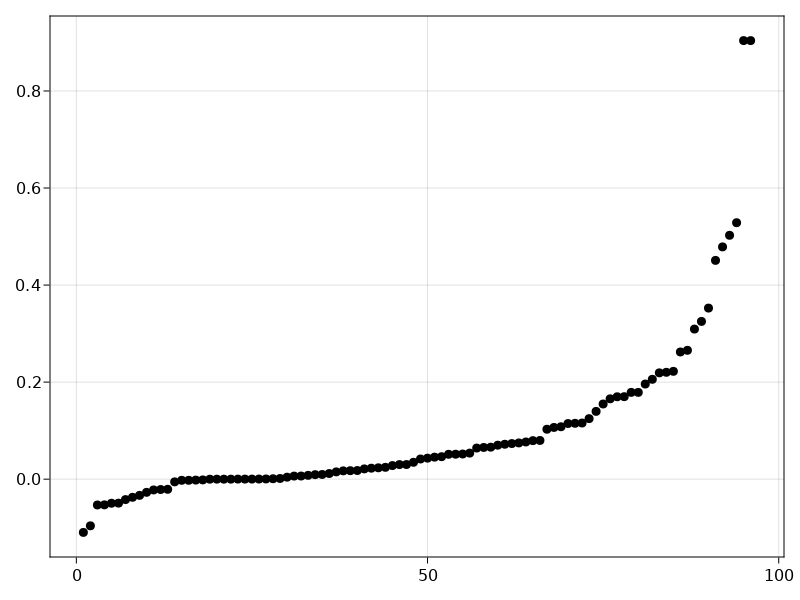

In [69]:
plot(sort(TEST_meanSilhouettes))

In [47]:
# import Pkg; Pkg.add(url="https://github.com/ahwillia/TimeWarp.jl.git")
import TimeWarp as tw


data = TEST

n = size(data,1)
dist_mat = zeros(n,n)
for i = 1:n
    for j = 1:n
        dist_mat[i,j] = tw.dtw(data[i,:],data[j,:])[1]
    end
end


In [49]:
sV = cl.silhouettes(TEST_labels, dist_mat)
sum(sV)/length(sV)

0.07212920662444097

In [45]:
# Prueba funcionamiento ds y cl
A = [1.1  0.9
     1.2  0.8
     0.9  0.7
     2.2  2.4
     2.3  2.3
     1.9  2.5]
display(A)
dist = ds.Euclidean()
D = ds.pairwise(dist, A, A, dims=1)
display(D)
L = [1,1,1,2,2,2] 

sV = cl.silhouettes(L, D)
sum(sV)/length(sV)

6×2 Matrix{Float64}:
 1.1  0.9
 1.2  0.8
 0.9  0.7
 2.2  2.4
 2.3  2.3
 1.9  2.5

6×6 Matrix{Float64}:
 0.0       0.141421  0.282843  1.86011   1.84391   1.78885
 0.141421  0.0       0.316228  1.8868    1.86011   1.83848
 0.282843  0.316228  0.0       2.14009   2.12603   2.05913
 1.86011   1.8868    2.14009   0.0       0.141421  0.316228
 1.84391   1.86011   2.12603   0.141421  0.0       0.447214
 1.78885   1.83848   2.05913   0.316228  0.447214  0.0

0.8582880647007989

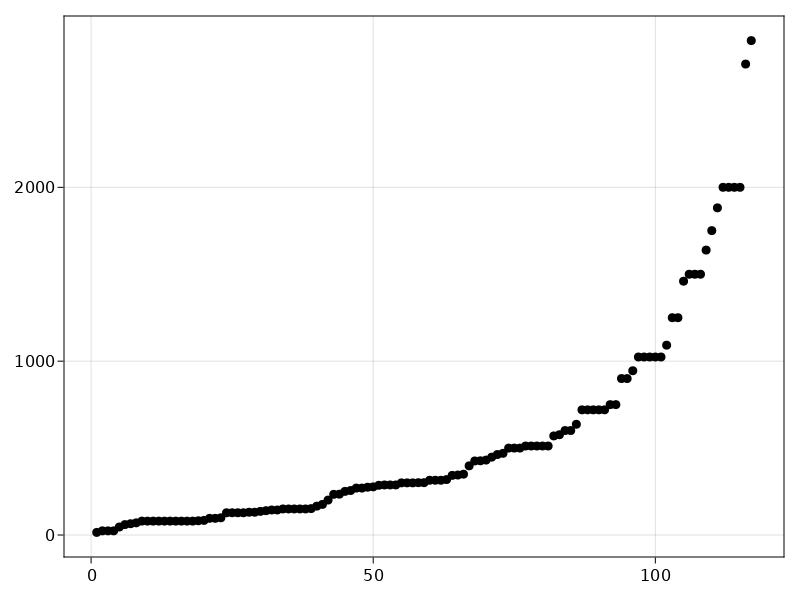

In [51]:
plot(sort(DataSumaryF_df.Length))

In [60]:
ID = 114

TEST, TEST_labels, TRAIN, TRAIN_labels = LoadDataBase(ID, DataSumaryF_df);
data = TEST
tw.dtw(data[1,:],data[2,:])[1]



159.75902430178272